<a href="https://colab.research.google.com/github/byambaa1982/CodingWorkshops/blob/master/oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Third approach


In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


## Read excel file

In [0]:
data = pd.read_excel('/Simulation Data (1).xlsx')

In [0]:
# sns.pairplot(data[['GOR', 'Oil gravity', 'Gas gravity', 'T', 'Pb', 'Bob']], diag_kind="kde")
# plt.show()

In [0]:
data=data[['GOR', 'Oil gravity', 'Gas gravity', 'T', 'Pb']]

## This shows the number of rows and columns in data frame

In [0]:
data.shape

(253, 5)

## Split data into train and test set

In [0]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [20]:
#This shows the number of rows and columns in data frame
train_dataset.shape

(202, 5)

## Also look at the overall statistics:

In [21]:
train_stats = train_dataset.describe()
train_stats.pop("Pb")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
GOR,202.0,575.509901,380.032471,26.000,285.500,553.5000,800.00000,1602.000
Oil gravity,202.0,0.922797,0.185278,0.627,0.779,0.9005,1.02725,1.367
Gas gravity,202.0,37.132178,32.373014,19.400,30.100,34.2000,39.40000,484.000
T,202.0,164.806931,45.489678,74.000,130.000,165.5000,195.75000,280.000


In [0]:
#  Split features from labels

#Separate the target value, or "label", from the features. This label is the 
#          value that you will train the model to predict.

train_labels = train_dataset.pop('Pb')
test_labels = test_dataset.pop('Pb')

In [23]:
train_stats.head

<bound method NDFrame.head of              count        mean         std  ...       50%        75%       max
GOR          202.0  575.509901  380.032471  ...  553.5000  800.00000  1602.000
Oil gravity  202.0    0.922797    0.185278  ...    0.9005    1.02725     1.367
Gas gravity  202.0   37.132178   32.373014  ...   34.2000   39.40000   484.000
T            202.0  164.806931   45.489678  ...  165.5000  195.75000   280.000

[4 rows x 8 columns]>

##   Normalize the data

Look again at the train_stats block above and note how different the ranges of 
each feature are.
It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, 
it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

## Xnorm =(X-Xmin)/(Xmax-Xmin)

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def tansig(n):
  return(2/(1+exp(-2*n))-1)

## Model building
According to the paper, LM algorithm with tansig transfer function and six neurons in the hidden layer provided the best performance in terms of estimating bubble point pressure by achieving the lowest values root mean square error along with the highest correlation coefficient. Further, it should be noted that, a linear transfer function (Purelin) was considered for the output layer. In total, the case 19 (i.e. the network with 4-6-1 structure) was found to be the optimum model for the estimation of bubble point pressure.

## Let's build our model. Here, we'll use a Sequential model with a densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.
Word "Sequential" is tensor library which cover "feed forward and backpropagate layers"

In [0]:
# Build the model 3 activation function is tanh


def build_model():
  model = keras.Sequential([ 
    layers.Dense(4, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(.01)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

## Class tf.keras.models.Sequential

##  optimizer = tf.keras.optimizers.Adam(.01)
Math explained below

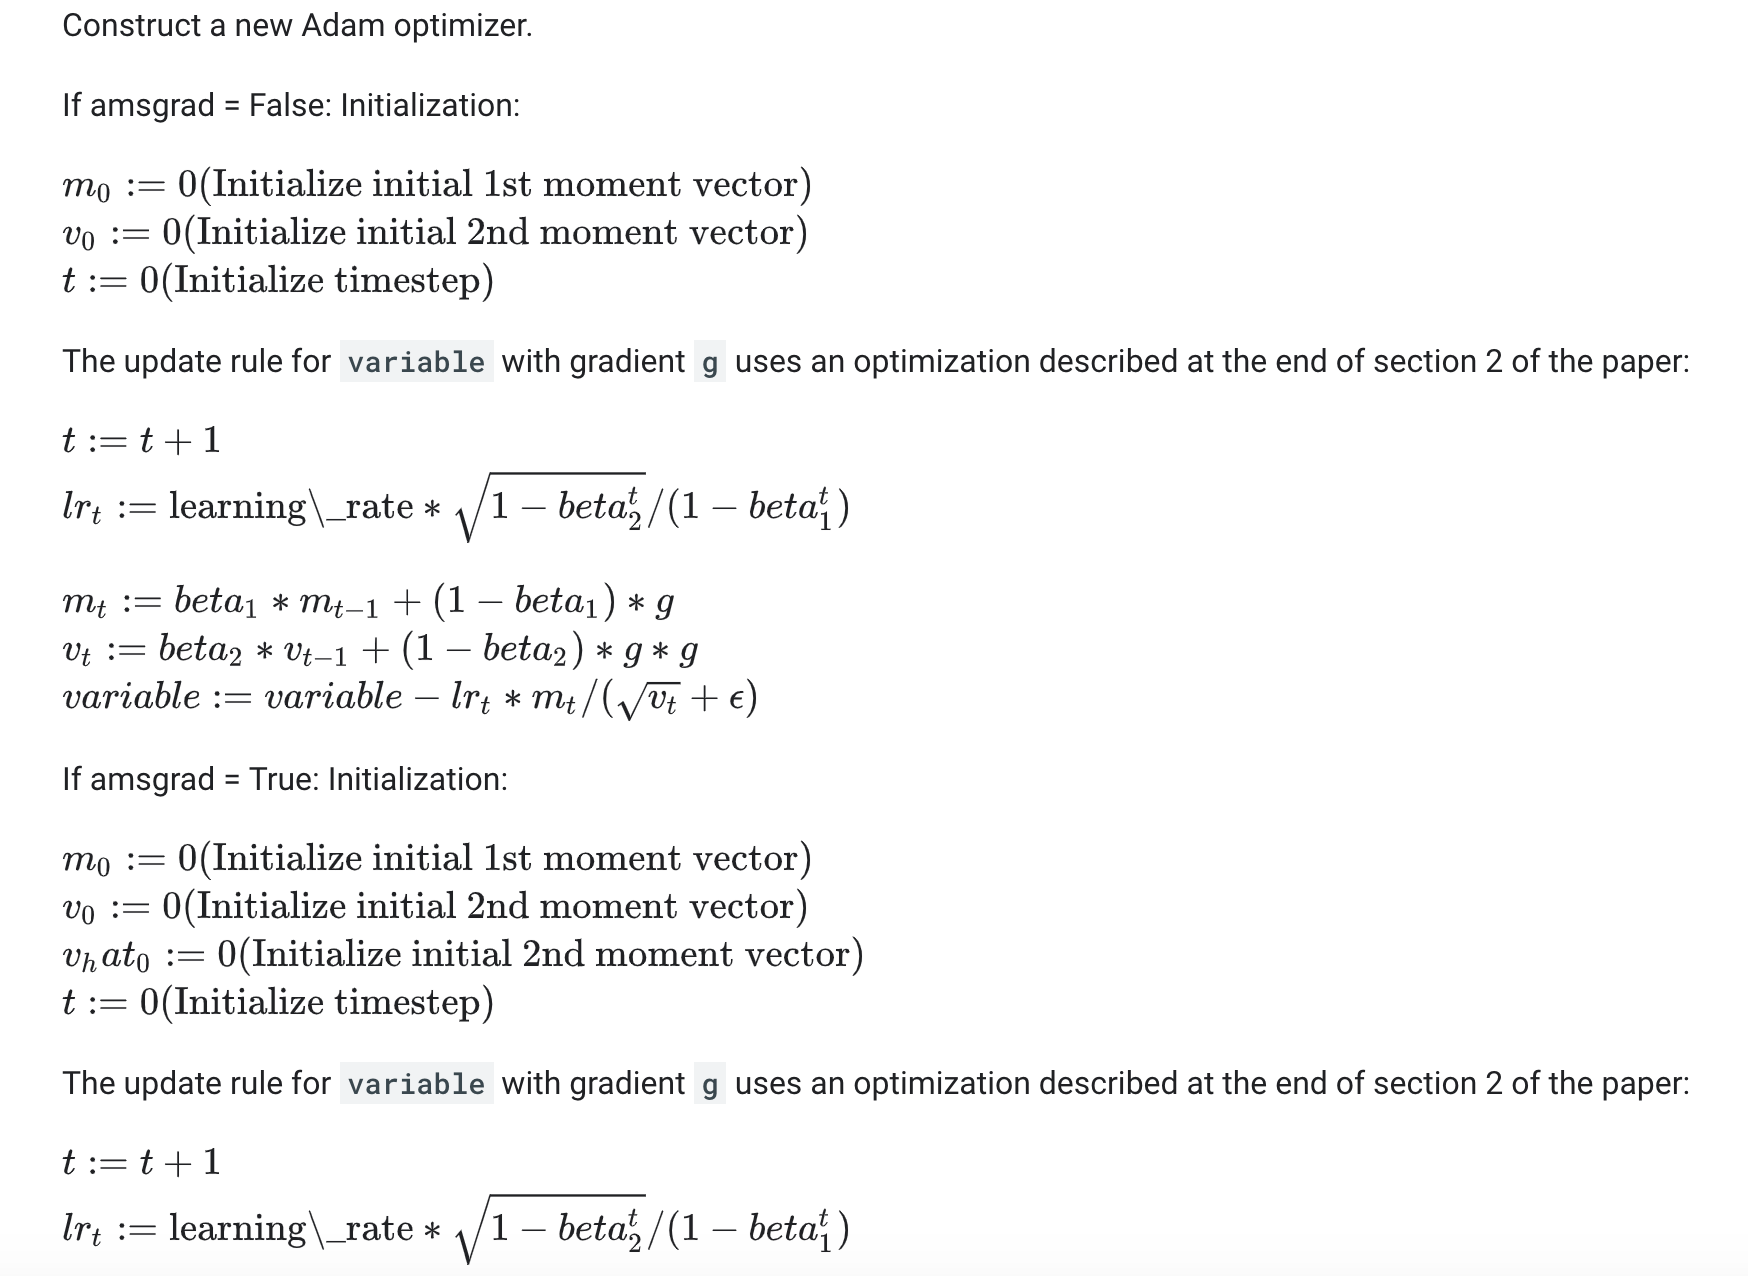

In [16]:
from IPython.display import Image
Image(filename='/scr.png')

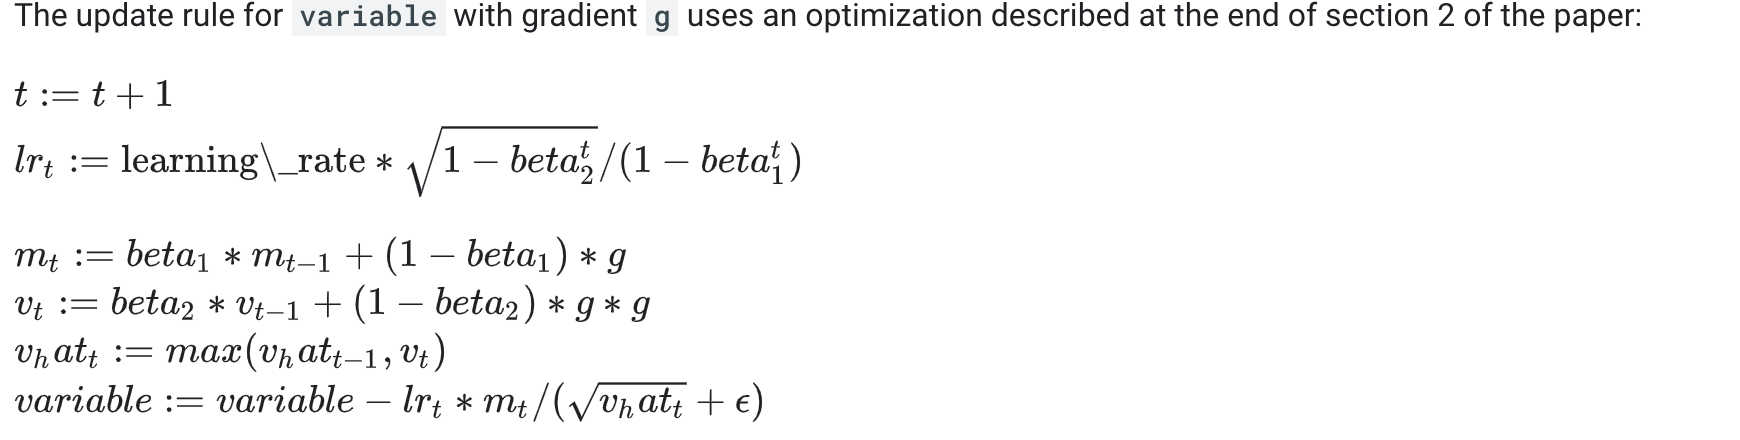

In [15]:
from IPython.display import Image
Image(filename='/scr.png')
Image(filename='/scr2.png')

In [29]:
model = build_model()

AttributeError: ignored

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Now try out the model. Take a batch of 10 examples 
#  from the training data and call model.predict on it.
example_batch = normed_train_data[:30]
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [ 1.0152563 ],
       [-0.21602276],
       [ 0.8778599 ],
       [ 0.152674  ],
       [ 0.07975368],
       [-0.09025314],
       [ 0.50761324],
       [ 0.26936233],
       [ 0.2687636 ],
       [ 0.00290918],
       [ 0.91393703],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 1.6264175 ],
       [-0.258115  ],
       [-0.33283913],
       [ 0.3727895 ],
       [ 0.20658989],
       [ 0.        ],
       [ 1.6837136 ],
       [ 0.7036712 ],
       [ 0.        ],
       [ 0.6217365 ],
       [ 0.3373367 ],
       [-0.5300175 ],
       [ 0.12770446],
       [ 0.00247738],
       [ 1.8435843 ]], dtype=float32)

In [28]:
# Train Model
# Display training progress by printing a single dot for each completed epoch


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

NameError: ignored

In [0]:
# Visualize the model's training progress using the stats stored 
#        in the history object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
1995,98069.131211,241.751099,98069.132812,268228.006479,334.413239,268228.00000,1995
1996,98099.612663,241.822998,98099.617188,268075.766959,334.339233,268075.75000,1996
1997,98120.726417,241.963898,98120.726562,268009.911585,334.298523,268009.90625,1997
1998,98194.715547,242.090088,98194.718750,267871.263148,333.748413,267871.28125,1998
1999,98163.870845,242.059341,98163.867188,267760.392340,333.200134,267760.37500,1999


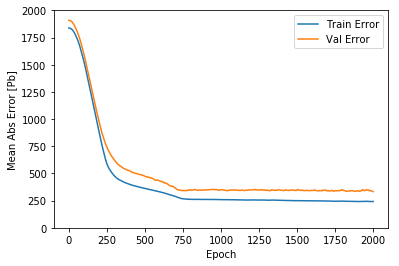

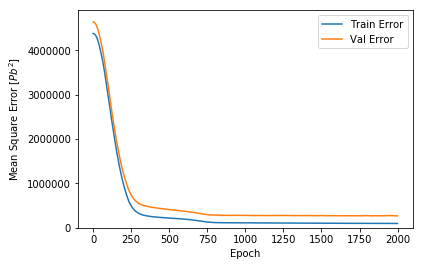

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Pb]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Pb^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,4900000])
  plt.legend()
  plt.show()


plot_history(history)

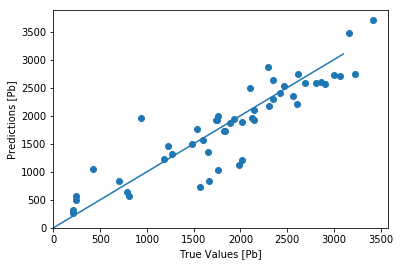

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Pb]')
plt.ylabel('Predictions [Pb]')
# plt.axis('equal')
# plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 3100], [0, 3100])

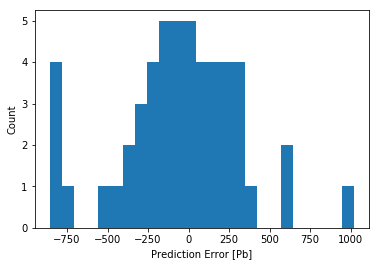

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Pb]")
_ = plt.ylabel("Count")

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
r2=metrics.r2_score(test_labels, test_predictions)

print("Testing set Mean Abs Error: {:5.2f} Pb".format(mae))
print("Testing set Mean Squared Error: {:5.2f} Pb".format(mse))
print("Testing loss: {:5.2f} Pb".format(loss))
print("r2 score:{:5.2f} Pb".format(r2))

Testing set Mean Abs Error: 279.09 Pb
Testing set Mean Squared Error: 140544.03 Pb
Testing loss: 140544.03 Pb
r2 score: 0.79 Pb


# Second approach with RELU

In [0]:
# Build the model


def build_model():
  model = keras.Sequential([
    layers.Dense(4, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [0]:
model = build_model()

In [0]:
# Inspect the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Now try out the model. Take a batch of 10 examples 
#  from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03319391],
       [-0.75236624],
       [ 0.17526613],
       [-0.37684235],
       [-0.13588846],
       [ 0.        ],
       [ 0.15729168],
       [-0.21955328],
       [-0.0533946 ],
       [-0.1555954 ]], dtype=float32)

In [0]:
# Train Model
# Display training progress by printing a single dot for each completed epoch


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 3000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
# Visualize the model's training progress using the stats stored 
#        in the history object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
2995,255417.800272,410.181000,255417.812500,460632.051067,521.929199,460632.06250,2995
2996,255298.505435,410.000580,255298.515625,460470.533537,521.650513,460470.53125,2996
2997,255221.998835,409.879456,255222.015625,460360.106707,521.563721,460360.09375,2997
2998,255146.154406,409.798187,255146.156250,460317.987043,521.516113,460318.00000,2998
2999,255100.348797,409.721313,255100.328125,460199.939787,521.298340,460199.93750,2999


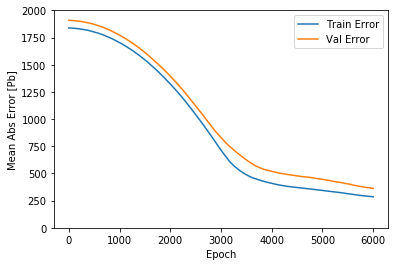

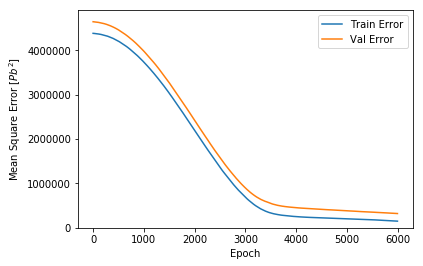

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Pb]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Pb^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,4900000])
  plt.legend()
  plt.show()


plot_history(history)

In [0]:
EPOCHS = 5500


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

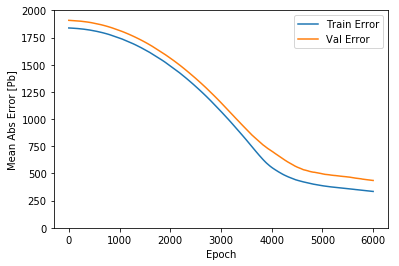

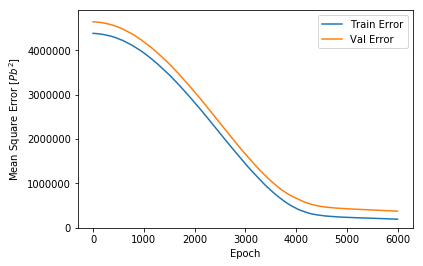

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Pb".format(mae))

Testing set Mean Abs Error: 409.11 Pb


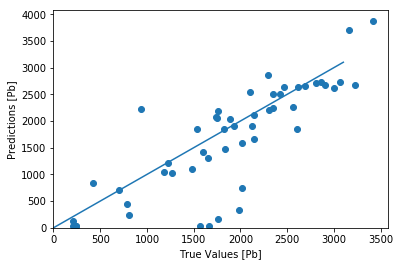

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Pb]')
plt.ylabel('Predictions [Pb]')
# plt.axis('equal')
# plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 3100], [0, 3100])

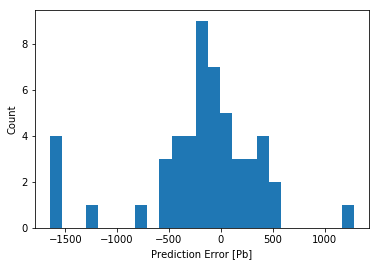

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Pb]")
_ = plt.ylabel("Count")

In [0]:
# Evaluate r^2
metrics.r2_score(test_labels, test_predictions)

0.47783778595442905